# Importation des modules et packages

### Webscrapping et importation des données

In [2]:
!pip install lxml
import requests 
import urllib
import bs4
import pandas as pd
from urllib import request
import re
from tqdm import tqdm
from scipy import *

### Visualisation et analyse des données

In [3]:
# Lecture et traitement du dataframe
import pandas as pd 
import numpy as np 

# Rapport sur les données pandas :
!pip install pandas_profiling 
!pip install ipywidgets
from pandas_profiling import ProfileReport

# Visualisation et analyse graphique des données
import matplotlib.pyplot as plt

# Visualisation et analyse cartographique des données
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install geopandas
import geopandas as gpd
import contextily as ctx

# Corrélation entre les données
import seaborn as sns 

### Modélisation

In [4]:
# Pour normaliser les données, on choisit MinMaxScaler de la librairie Sklearn
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

#
from sklearn.linear_model import Ridge

#
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, explained_variance_score

----------------------------------------------------------------------------------------------------------------

# Récupération des données 

## WebScrapping des noms de films sur Wikipédia 

On stocke tous les noms des films présents sur cette page dans une liste que l'on appelle Liste_films.
On modifie le format de certains titre : ' XXX (1967)' devient ' XXX '.\
Finalement, on récupère la longueur de la liste : elle est de ≈ 1500. 

In [4]:
response = requests.get(
	url="https://en.wikipedia.org/wiki/List_of_years_in_film",
)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

List of years in film


In [5]:
all_names= soup.findAll("i")
L=[]
for link in all_names :
    t=link.findAll('a')
    if len(t)!=0:
        r=t[0]['title']
        L.append(r)
# print(L)

On enlève les précisions entre parenthèses 

In [6]:
Liste_films= []
for i in L: 
    Liste_films.append(re.sub("\(.*?\)","()",i).replace("()",""))
#print(L2)
len(Liste_films)

1542

## Utilisation d'une API pour récupérer l'identifiant des films à partir de leur titre

On utilise l'API: The Movie Database API (TMDB API) pour laquelle nous avons dû faire une demande de clé : api_key\
On place ces identifiants dans une liste index.

### Cas particulier : on fixe le nom du film

On va utiliser une première requête d'API pour accéder aux ID des films scrappés sur Wikipédia.

In [7]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 
nom_du_film='Earth '

url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom_du_film}" 

#requête pour trouver les infos ayant le nom_du_film en title 
req = requests.get(url_api)
wb = req.json()

# on récupère tous les indexs des films en question 
index=[]
for film in range(len(wb['results'])):
    index.append(wb['results'][film]['id'])
index  

[811367,
 82700,
 10946,
 31642,
 748853,
 443297,
 11569,
 197624,
 55420,
 5491,
 85949,
 88751,
 16300,
 68179,
 697960,
 13539,
 347111,
 464593,
 339,
 13363]

##### Création d'une fonction qui renvoie, à titre fixé, tous les index des films scrappés sur Wikipedia.

In [8]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 

def get_id(nom):
    url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom}" 
    #requête pour trouver les infos ayant le nom_du_film en title 
    req = requests.get(url_api)
    wb = req.json()


    # on récupère tous les indexs des films en question 
    index=[]
    for film in range(len(wb['results'])):
        index.append(wb['results'][film]['id'])
    return(index)



##### Récupération du détail des données grâce à une autre API 

Toujours sur TMDB API, on utilise cette fois l'id du film pour accéder à un grand nombre de données sur ce film : get detail. 
Pour cela on fait appel à la fonction précédente qui nous donnait les id correspondant au titre du film. 
On ajuste le format des données pour que les tailles des éléments nous permettent de convertir le dictionnaire
en DataFrame pandas. 

In [9]:
def df_avec_id(id):
    id_film= id
    url_new_api = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={api_key}&language=en-US"
    req_new = requests.get(url_new_api)
    wb_new = req_new.json()
    
    
    #ajustement des données 
    if wb_new['belongs_to_collection']!=None: 
        wb_new['belongs_to_collection']=wb_new['belongs_to_collection']['name']
        
    wb_new['genres']=' , '.join([x['name'] for x in wb_new['genres']]) #on ne sélectionne que le nom des genres 
    wb_new['production_companies']=' , '.join([x['name'] for x in wb_new['production_companies']]) #on ne sélectionne que les noms (même pas les pays)
    wb_new['production_countries']=' , '.join([x['name'] for x in wb_new['production_countries']])
    wb_new['spoken_languages']=' , '.join([x['name'] for x in wb_new['spoken_languages']])
    
    df=pd.DataFrame(wb_new, index=[wb_new['id']])  #j'ai mis l'ID en index mais on peut aussi indexer à partie de 0
    # pour cela, on met index=[0]
    
    return (df)

### Généralisation et concaténation

On utilise les deux fonctions précédentes pour créer notre DataFrame all. 
On parcourt la liste des titres puis la liste des id pour chacun des films. 
On a donc une double-boucle for, ce qui s'avère couteux mais qui fonctionne au bout d'1h30. 

Un axe d'amélioration serait de réduire le temps pour cette collecte de données. 

In [10]:
def concat_all(liste):
    Liste_fail=[]
    
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        for i in ind:
            try:
                df_2=df_avec_id(i)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    DF_ALL=pd.concat([DF_ALL,df_2],axis=0)
                    
            except ValueError:
                Liste_fail.append([nom,i])
    print(Liste_fail)
    return DF_ALL

In [11]:
def concat_all_2(liste):
    Liste_fail=[]
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        f_vect(ind)
    print(Liste_fail)
    return DF_ALL

In [12]:
def fonction_int(id):
    try:
                df_2=df_avec_id(id)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    return(pd.DataFrame())
                    
    except ValueError:
                Liste_fail.append(id)
            

f_vect = np.vectorize(fonction_int)

In [13]:
l=Liste_films
a=concat_all(l)

100%|██████████| 1542/1542 [21:14<00:00,  1.21it/s]

[]


In [14]:
a.head(5)

adult                     backdrop_path  belongs_to_collection  \
624860  False  /eNI7PtK6DEYgZmHWP9gQNuff8pv.jpg  The Matrix Collection   
603     False  /l4QHerTSbMI7qgvasqxP36pqjN6.jpg  The Matrix Collection   
604     False  /pxK1iK6anS6erGg4QePmMKbB1E7.jpg  The Matrix Collection   
605     False  /533xAMhhVyjTy8hwMUFEt5TuDfR.jpg  The Matrix Collection   
13764   False  /xLDSKsyAGFFCNYDmNynEOsms5jp.jpg                   None   

           budget                                           genres  \
624860  190000000             Science Fiction , Action , Adventure   
603      63000000                         Action , Science Fiction   
604     150000000  Adventure , Action , Thriller , Science Fiction   
605     150000000  Adventure , Action , Thriller , Science Fiction   
13764    50000000                     Family , Fantasy , Adventure   

                                homepage      id     imdb_id  \
624860   https://www.whatisthematrix.com  624860  tt10838180   
603     http://www.warnerbros.com/matrix     603   tt0133093   
604                                          604   tt0234215   
605                                          605   tt0242653   
13764                                      13764   tt0089961   

       original_language            original_title  ... release_date  \
624860                en  The Matrix Resurrections  ...   2021-12-16   
603                   en                The Matrix  ...   1999-03-30   
604                   en       The Matrix Reloaded  ...   2003-05-15   
605                   en    The Matrix Revolutions  ...   2003-11-05   
13764                 en    Santa Claus: The Movie  ...   1985-10-29   

          revenue runtime    spoken_languages    status  \
624860  156497322     147             English  Released   
603     463517383     136             English  Released   
604     738599701     138             English  Released   
605     424988211     129  English , Français  Released   
13764    23717291     108             English  Released   

                                            tagline                     title  \
624860                        Return to the source.  The Matrix Resurrections   
603                      Welcome to the Real World.                The Matrix   
604                                 Free your mind.       The Matrix Reloaded   
605     Everything that has a beginning has an end.    The Matrix Revolutions   
13764                   Guess who's coming to town!    Santa Claus: The Movie   

        video vote_average vote_count  
624860  False        6.582       4334  
603     False        8.195      22428  
604     False        7.026       9448  
605     False        6.701       8493  
13764   False        6.289        206  

[5 rows x 25 columns]

## Création d'un fichier .csv
On va exporter ce fichier en csv pour ne pas à recharger à chaque fois car le chargement est chronophage (temps estimé : 30 minutes).

On enregistre le Dataframe all sous un fichier au format csv.

In [6]:
a.to_csv('Projet_films.csv',index=False) 

On vient charger le fichier 'ProjetFilms.csv' dans notre code pour pouvoir l'exploiter ensuite.

In [8]:
df=pd.read_csv('Projet_films.csv')

----------------------------------------------------------------------------------------------------------------

# Visualisation et analyse des données

In [9]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Nettoyage des données 

### Variables utiles
 
On commence par chercher les variables utiles pour notre analyse des données puis pour notre modèle de prédiction. 

D'après le Profile Report du début, on observe que tous les films sont classés "Adult", cette variable n'a donc ici que peu d'intérêt. 
On fait le choix de ne pas prendre en compte les variables suivantes pour notre modèle:
- adult 
- backdrop_path
- homepage
- id 
- imdb_id
- original title
- overview
- poster_path 

In [10]:
df.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [11]:
df_bis= df[['belongs_to_collection','budget','genres','original_language','production_countries','popularity','production_companies','release_date','revenue','runtime','spoken_languages','status']]

On ne garde que les films qui sont sortis 

In [12]:
df_bis=df_bis[df_bis.status=='Released']

On change le type des dates maintenant, il s'agit bien de datetime

In [13]:
df_bis.release_date=pd.to_datetime(df_bis.release_date, format='%Y-%m-%d', errors = 'ignore')

In [14]:
df_bis= df_bis[df_bis.runtime!=0]

In [15]:
df_bis['release_year']=df_bis['release_date'].dt.year 
df_bis['release_month']=df_bis['release_date'].dt.month 
df_bis['release_day']=df_bis['release_date'].dt.day 

On enlève les warnings causés pas le .iloc 

In [16]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

On retire les films dont le revenu n'est pas disponible (revenu fixé à 0 dans le dataset)

In [17]:
df_bis = df_bis[df_bis['revenue'] != 0]

### Résolution des problèmes du dataset
On travaille à présent sur les variables (genres, production countries...) de manière à obtenir un jeu données propre et exploitable. Pour cela, on va créer pour chaque genre une variable "Nom_du_Genre" ("Action" par exemple) qui vaudra 1 si le film appartient à ce genre et 0 sinon. De même pour la nationalité. Et enfin, de même pour la saga (créer une variable qui prend la valeur 1 si le film est une saga, 0 sinon).

#### La variable 'genre'
On va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le problème de la multiappartenance.

In [50]:
Liste_genres= df_bis['genres'].unique()
p = re.compile(r'\W+')

Liste_finale=[]

for i in Liste_genres : 
    #print(str(i))
    sous_liste= p.split(str(i))
    for j in sous_liste :
        Liste_finale.append(j)
        
Liste_genre_finale = np.unique(Liste_finale)     
Liste_genre_finale

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History',
       'Horror', 'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'TV',
       'Thriller', 'War', 'Western', 'nan'], dtype='<U11')

In [51]:
for genre in Liste_genre_finale:
    df_bis[genre]= df_bis['genres'].str.contains(genre, case=False).astype(bool).astype(int)
df_bis.head(5)

belongs_to_collection     budget  \
0  The Matrix Collection  190000000   
1  The Matrix Collection   63000000   
2  The Matrix Collection  150000000   
3  The Matrix Collection  150000000   
4                    NaN   50000000   

                                            genres original_language  \
0             Science Fiction , Action , Adventure                en   
1                         Action , Science Fiction                en   
2  Adventure , Action , Thriller , Science Fiction                en   
3  Adventure , Action , Thriller , Science Fiction                en   
4                     Family , Fantasy , Adventure                en   

       production_countries  popularity  \
0  United States of America     213.259   
1  United States of America      77.938   
2  United States of America      40.939   
3  United States of America      37.752   
4  United States of America      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime  ... Spain Sweden  Switzerland  Taiwan  Turkey  Ukraine  \
0      148  ...     0      0            0       0       0        0   
1      136  ...     0      0            0       0       0        0   
2      138  ...     0      0            0       0       0        0   
3      129  ...     0      0            0       0       0        0   
4      108  ...     0      0            0       0       0        0   

   United Arab Emirates  United Kingdom  United States of America  Vietnam  
0                     0               0                         1        0  
1                     0               0                         1        0  
2                     0               0                         1        0  
3                     0               0                         1        0  
4                     0               0                         1        0  

[5 rows x 96 columns]

#### La variable 'production_countries'
On fait de même qu'avec les genres : on va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le problème de la multiappartenance.

In [20]:
Liste_pays_prod= df_bis['production_countries'].unique()
Liste_finale=[]

for i in Liste_pays_prod : 
    #print(str(i))
    sous_liste= re.split(' ; | , ', str(i))
    for j in sous_liste :
        Liste_finale.append(j)
        
Liste_finale = np.unique(Liste_finale)     
Liste_finale

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'China',
       'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'India', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico',
       'Morocco', 'Netherlands', 'New Zealand', 'Norway', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Romania', 'Russia', 'Slovenia', 'South Africa', 'South Korea',
       'Soviet Union', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Vietnam', 'nan'], dtype='<U24')

In [21]:
for pays in Liste_finale:
    df_bis[pays]= df_bis['production_countries'].str.contains(pays, case=False).astype(bool).astype(int)
df_bis.head(5)

belongs_to_collection     budget  \
0  The Matrix Collection  190000000   
1  The Matrix Collection   63000000   
2  The Matrix Collection  150000000   
3  The Matrix Collection  150000000   
4                    NaN   50000000   

                                            genres original_language  \
0             Science Fiction , Action , Adventure                en   
1                         Action , Science Fiction                en   
2  Adventure , Action , Thriller , Science Fiction                en   
3  Adventure , Action , Thriller , Science Fiction                en   
4                     Family , Fantasy , Adventure                en   

       production_countries  popularity  \
0  United States of America     213.259   
1  United States of America      77.938   
2  United States of America      40.939   
3  United States of America      37.752   
4  United States of America      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime  ... Spain Sweden  Switzerland  Taiwan  Turkey  Ukraine  \
0      148  ...     0      0            0       0       0        0   
1      136  ...     0      0            0       0       0        0   
2      138  ...     0      0            0       0       0        0   
3      129  ...     0      0            0       0       0        0   
4      108  ...     0      0            0       0       0        0   

   United Arab Emirates  United Kingdom  United States of America  Vietnam  
0                     0               0                         1        0  
1                     0               0                         1        0  
2                     0               0                         1        0  
3                     0               0                         1        0  
4                     0               0                         1        0  

[5 rows x 96 columns]

In [22]:
df_bis.head(5)

belongs_to_collection     budget  \
0  The Matrix Collection  190000000   
1  The Matrix Collection   63000000   
2  The Matrix Collection  150000000   
3  The Matrix Collection  150000000   
4                    NaN   50000000   

                                            genres original_language  \
0             Science Fiction , Action , Adventure                en   
1                         Action , Science Fiction                en   
2  Adventure , Action , Thriller , Science Fiction                en   
3  Adventure , Action , Thriller , Science Fiction                en   
4                     Family , Fantasy , Adventure                en   

       production_countries  popularity  \
0  United States of America     213.259   
1  United States of America      77.938   
2  United States of America      40.939   
3  United States of America      37.752   
4  United States of America      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime  ... Spain Sweden  Switzerland  Taiwan  Turkey  Ukraine  \
0      148  ...     0      0            0       0       0        0   
1      136  ...     0      0            0       0       0        0   
2      138  ...     0      0            0       0       0        0   
3      129  ...     0      0            0       0       0        0   
4      108  ...     0      0            0       0       0        0   

   United Arab Emirates  United Kingdom  United States of America  Vietnam  
0                     0               0                         1        0  
1                     0               0                         1        0  
2                     0               0                         1        0  
3                     0               0                         1        0  
4                     0               0                         1        0  

[5 rows x 96 columns]

In [242]:
df_ter=df_bis.drop(['genres', 'production_countries'], axis=1, inplace = False)

In [243]:
df_ter.head(5)

belongs_to_collection     budget original_language  popularity  \
0  The Matrix Collection  190000000                en     213.259   
1  The Matrix Collection   63000000                en      77.938   
2  The Matrix Collection  150000000                en      40.939   
3  The Matrix Collection  150000000                en      37.752   
4                    NaN   50000000                en      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime    spoken_languages    status  ...  Spain  Sweden  Switzerland  \
0      148             English  Released  ...      0       0            0   
1      136             English  Released  ...      0       0            0   
2      138             English  Released  ...      0       0            0   
3      129  English , Français  Released  ...      0       0            0   
4      108             English  Released  ...      0       0            0   

   Taiwan  Turkey  Ukraine  United Arab Emirates  United Kingdom  \
0       0       0        0                     0               0   
1       0       0        0                     0               0   
2       0       0        0                     0               0   
3       0       0        0                     0               0   
4       0       0        0                     0               0   

   United States of America  Vietnam  
0                         1        0  
1                         1        0  
2                         1        0  
3                         1        0  
4                         1        0  

[5 rows x 94 columns]

#### La variable saga / 'b_to_c'
On crée une nouvelle variable b_to_c qui vaut 1 ou 0 en fonction de si le film appartient à une collection ou pas.


In [244]:
df_ter['b_to_c']=pd.notnull(df_ter['belongs_to_collection']) #devient True et False
df_ter['b_to_c']=df_ter['b_to_c'].apply( lambda x : int(x))
df_ter.drop(['belongs_to_collection','production_companies','spoken_languages','status'], axis=1, inplace = True)
df_ter.head(5)

budget original_language  popularity release_date    revenue  runtime  \
0  190000000                en     213.259   2021-12-16  156497322      148   
1   63000000                en      77.938   1999-03-30  463517383      136   
2  150000000                en      40.939   2003-05-15  738599701      138   
3  150000000                en      37.752   2003-11-05  424988211      129   
4   50000000                en      11.490   1985-10-29   23717291      108   

   release_year  release_month  release_day  Action  ...  Sweden  Switzerland  \
0        2021.0           12.0         16.0       1  ...       0            0   
1        1999.0            3.0         30.0       1  ...       0            0   
2        2003.0            5.0         15.0       1  ...       0            0   
3        2003.0           11.0          5.0       1  ...       0            0   
4        1985.0           10.0         29.0       0  ...       0            0   

   Taiwan  Turkey  Ukraine  United Arab Emirates  United Kingdom  \
0       0       0        0                     0               0   
1       0       0        0                     0               0   
2       0       0        0                     0               0   
3       0       0        0                     0               0   
4       0       0        0                     0               0   

   United States of America  Vietnam  b_to_c  
0                         1        0       1  
1                         1        0       1  
2                         1        0       1  
3                         1        0       1  
4                         1        0       0  

[5 rows x 91 columns]

#### La variable 'language'
On crée une nouvelle variable 'language' qui vaut 1 si la langue est parlée dans le film, 0 sinon.


In [245]:
orig_language=pd.get_dummies(df_ter['original_language'],drop_first=True)

In [246]:
Liste_des_langues = [i for i in orig_language.sum().sort_values(ascending=False).index[:5]]
Liste_des_langues.append('Others')
Liste_des_langues

['en', 'ja', 'fr', 'it', 'de', 'Others']

In [247]:
for langue in Liste_des_langues:
    if langue!='Others':
        df_ter[langue + '_original']= df_ter['original_language'].str.contains(langue, case=False).astype(bool).astype(int)
    else: 
        df_ter[langue +  '_original']= df_ter["original_language"].apply(lambda x: x not in Liste_des_langues).astype(int)
    df_ter

In [248]:
df_ter.drop(['original_language','release_date'], axis=1, inplace = True)

In [249]:
df_ter.head(5)

budget  popularity    revenue  runtime  release_year  release_month  \
0  190000000     213.259  156497322      148        2021.0           12.0   
1   63000000      77.938  463517383      136        1999.0            3.0   
2  150000000      40.939  738599701      138        2003.0            5.0   
3  150000000      37.752  424988211      129        2003.0           11.0   
4   50000000      11.490   23717291      108        1985.0           10.0   

   release_day  Action  Adventure  Animation  ...  United Kingdom  \
0         16.0       1          1          0  ...               0   
1         30.0       1          0          0  ...               0   
2         15.0       1          1          0  ...               0   
3          5.0       1          1          0  ...               0   
4         29.0       0          1          0  ...               0   

   United States of America  Vietnam  b_to_c  en_original  ja_original  \
0                         1        0       1            1            0   
1                         1        0       1            1            0   
2                         1        0       1            1            0   
3                         1        0       1            1            0   
4                         1        0       0            1            0   

   fr_original  it_original  de_original  Others_original  
0            0            0            0                0  
1            0            0            0                0  
2            0            0            0                0  
3            0            0            0                0  
4            0            0            0                0  

[5 rows x 95 columns]

## Visualisation et analyse graphique

Regardons si l'on peut trouver des liens entre nos données descriptives et les revenus générés par les films sélectionnés (le revenu du film étant, dans la partie modélisation, ce que l'on cherchera à prédir).

Nous utilisons "xlim" et "ylim" pour écarter quelques valeurs extrêmes et avoir une vision plus claire de la plus grande partie de nos données.

Nous mettons aussi le revenu au logarithme pour limiter la dispersion de cette variable.

#### Lien Nombre de critiques reçues par le film - Chiffre d'affaires du film ?

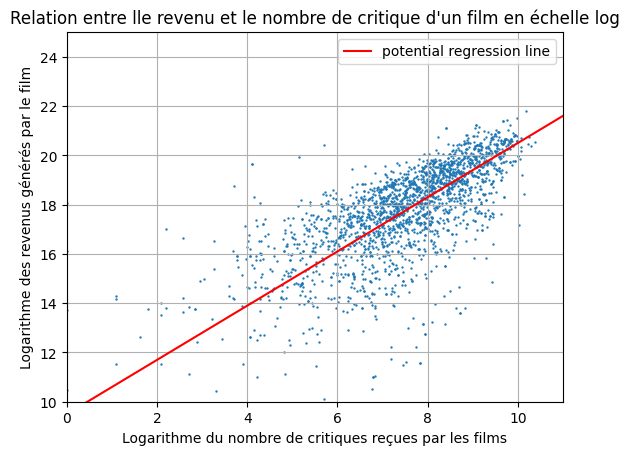

In [34]:
plt.scatter(np.log(df["vote_count"]), np.log(df["revenue"]), s = 2, marker = ".")
plt.xlim([0,11])
plt.ylim([10,25])
plt.xlabel("Logarithme du nombre de critiques reçues par les films")
plt.ylabel("Logarithme des revenus générés par le film")
def f(x):
    return 1.1*x + 9.5
plt.plot([f(x) for x in range(30)], color = 'r', label = "potential regression line") 
plt.legend(loc='best')
plt.grid()
plt.title("Relation entre lle revenu et le nombre de critique d'un film en échelle log")
plt.show()

On observe un lien qui semble linéaire entre le logarithme du nombre de critiques reçues par les films et le logarithme des revenus générés par les films de notre DataFrame. Una augmentation en pourcentage du nombre de critiques semble donc augmenter d'un certain pourcentage les revenus des films. 

#### Lien Budget de réalisation du film - Chiffre d'affaires du film ?

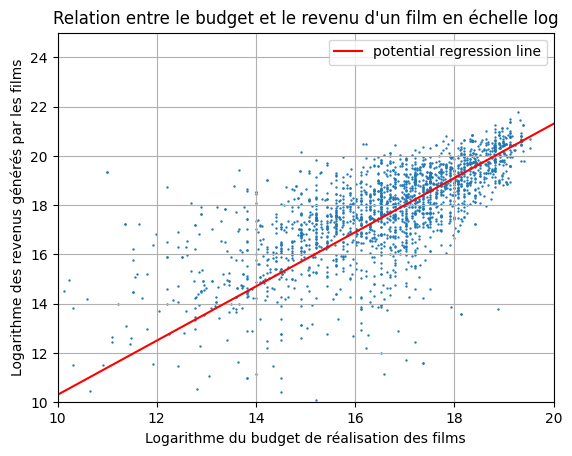

In [33]:
plt.scatter(np.log(df_ter["budget"]), np.log(df_ter["revenue"]), s = 2, marker = ".")
plt.xlim([10,20])
plt.ylim([10,25])
plt.xlabel("Logarithme du budget de réalisation des films")
plt.ylabel("Logarithme des revenus générés par les films")
def f(x):
    return 1.1*x - 0.7
plt.plot([f(x) for x in range(30)], color = 'r', label = "potential regression line") 
plt.legend(loc='best')
plt.title("Relation entre le budget et le revenu d'un film en échelle log")
plt.grid()
plt.show()

De la même façon, on observe un lien qui semble linéaire entre le logarithme des budgets des films et le logarithme des revenus générés par les films de notre DataFrame. Una augmentation en pourcentage du budget semble donc augmenter d'un certain pourcentage les revenus des films. La dispersion semble de plus se réduire quand le budget augmente.

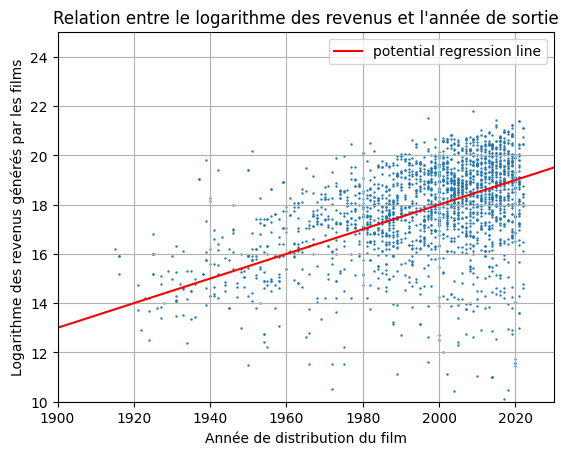

In [35]:
plt.scatter(df_ter["release_year"], np.log(df_ter["revenue"]), s = 2, marker = ".")
plt.ylim([10,25])
plt.xlim([1900,2030])
plt.xlabel("Année de distribution du film")
plt.ylabel("Logarithme des revenus générés par les films")
def f(x):
    return 0.05*x - 82
plt.plot([f(x) for x in range(2500)], color = 'r', label = "potential regression line") 
plt.legend(loc='best')
plt.grid()
plt.title("Relation entre le logarithme des revenus et l'année de sortie")
plt.show()

On observe un lien qui semble linéaire entre l'année de distribution des films et le logarithme des revenus générés par les films. Les films plus récents semble donc générer un pourcentage plus élevé de revenus.

#### Lien Note moyenne du film par vote des spectateurs - Chiffre d'affaires du film ?

Text(0, 0.5, 'Revenus générés par le film (en milliards de dollars)')

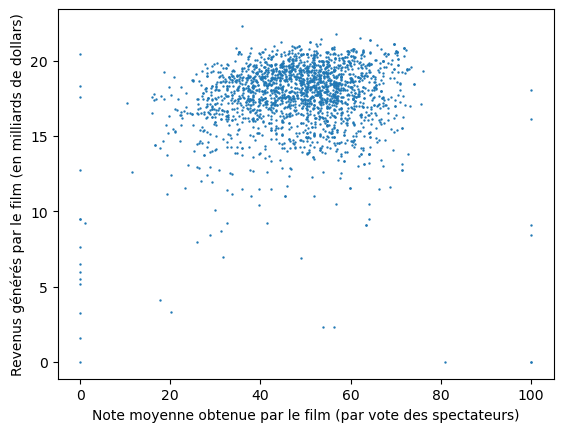

In [77]:
plt.scatter(df["vote_average"]**2, np.log(df["revenue"]), s = 2, marker = ".")
#plt.xlim([1,2.25])
#plt.ylim([10,22])
plt.xlabel("Note moyenne obtenue par le film (par vote des spectateurs)")
plt.ylabel("Revenus générés par le film (en milliards de dollars)")

Pour d'autres variables (ici la note moyenne reçue par le film) la relation est moins évidente.

## Visualisation et analyse cartographique des données

#### Lien Pays de réalisation du film - Chiffre d'affaires du film ?

#### Lien Langues parlées dans le film - Chiffre d'affaires du film ?

In [75]:
import plotly.graph_objects as go

In [175]:
from matplotlib import colors as mcolors


def pastel(colour, weight=2.4):
    """ Convert colour into a nice pastel shade"""
    rgb = np.asarray(mcolors.to_rgba(colour)[:3])
    # scale colour
    maxc = max(rgb)
    if maxc < 1.0 and maxc > 0:
        # scale colour
        scale = 1.0 / maxc
        rgb = rgb * scale
    # now decrease saturation
    total = rgb.sum()
    slack = 0
    for x in rgb:
        slack += 1.0 - x

    # want to increase weight from total to weight
    # pick x s.t.  slack * x == weight - total
    # x = (weight - total) / slack
    x = (weight - total) / slack

    rgb = [c + (x * (1.0 - c)) for c in rgb]

    return rgb


def get_colours(n):
    """ Return n pastel colours. """
    base = np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

    if n <= 3:
        return base[0:n]

    # how many new colours to we need to insert between
    # red and green and between green and blue?
    needed = (((n - 3) + 1) / 2, (n - 3) / 2)

    colours = []
    for start in (0, 1):
        for x in np.linspace(0, 1, needed[start] + 2):
            colours.append((base[start] * (1.0 - x)) +
                           (base[start + 1] * x))

    return [pastel(c) for c in colours[0:n]]

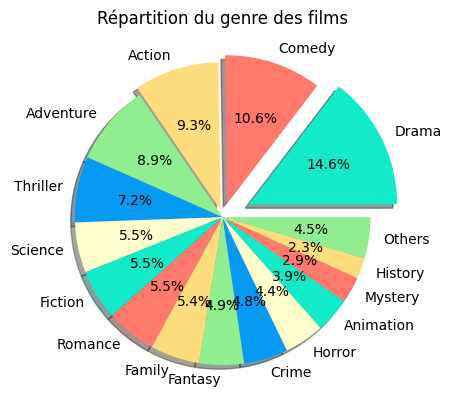

In [185]:
L=[]
Genres=[]
for genre in Liste_genre_finale:
    l=0
    l=df_ter[genre].sum()
    L.append(l)
    Genres.append(genre)
#print(L) 
O=pd.DataFrame({'Count': L , 'Genre': Genres })
O.sort_values(by='Count', ascending=False, inplace=True)

DF=O[:15]
autre= O[15:].Count.sum()
Liste=list(DF.Count)
Liste.append(autre)
Labels=list(DF.Genre)
Labels.append("Others")

colors= ['#13EAC9','#FF796C','#FBDD7E','#90EE90','#069AF3','#FFFFCB']
myexplode = [0.2, 0.1, 0.05, 0,0,0,0,0,0,0,0,0,0,0,0,0]

plt.pie(Liste, labels = Labels, explode = myexplode, colors=colors,autopct='%1.1f%%', startangle=0, shadow = True)
plt.title("Répartition du genre des films")
plt.show() 

----------------------------------------------------------------------------------------------------------------

# Modélisation

## Preprocessing

On utilise le dataset le plus propres "df_ter", travaillé prélablement, duquel on retire les NaNs pour pouvoir créer un algorithme de modélisation.

In [361]:
df_4=df_ter.copy()

In [362]:
df_4.dropna(inplace=True)

In [363]:
df_4.revenue=np.log(df_4.revenue)
df_4.budget=np.log(df_4.budget)

In [364]:
X=df_4.drop(['revenue'],axis=1)
y= df_4['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )
X_t=X_train.copy()

In [365]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

In [366]:
scaler=StandardScaler() #MinMaxScaler
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.fit_transform(X_test)

/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.

/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.

/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.

/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised i

In [367]:
model=RidgeCV()
model.fit(X_train,y_train)

predictions = model.predict(X_test)
print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6583071258623114
model score on testing data: 0.3798306894886718


On a un meilleur score en mettant le Revenu et le budget en log 

In [368]:
print( "La Mean Absolute Percentage Error (MAPE) est de " + str(mean_absolute_percentage_error(y_test, predictions)))
print( "La Mean Absolute Error (MAE) est de " + str(mean_absolute_error(y_test, predictions)))
print( "La Mean Squared Error (MSE) est de " + str(mean_squared_error(y_test, predictions)))
print( "Le Explained Variance Score est de " + str(explained_variance_score(y_test, predictions)))

La Mean Absolute Percentage Error (MAPE) est de 0.0750186719026753
La Mean Absolute Error (MAE) est de 1.0824901835320722
La Mean Squared Error (MSE) est de 3.2549207508410456
Le Explained Variance Score est de 0.3835532761514767


In [369]:
X_t

budget  popularity  runtime  release_year  release_month  \
813   16.835935      39.857       99        1983.0            7.0   
2697  17.926384     175.208       97        2021.0            5.0   
2214  17.909855      24.910      117        2002.0           12.0   
2202  18.450240      82.818      100        2013.0            5.0   
657   18.348110      64.804      105        2011.0            8.0   
...         ...         ...      ...           ...            ...   
2037  17.504390     573.596       77        2005.0            9.0   
2033  18.826146      83.284       89        2008.0           10.0   
2116  17.034386      23.691      113        2007.0            5.0   
1354  15.424948      10.155       97        2007.0            9.0   
1954  15.894952      19.131      110        2003.0           12.0   

      release_day  Action  Adventure  Animation  Comedy  ...  United Kingdom  \
813          22.0       0          0          0       0  ...               0   
2697         21.0       0          0          0       0  ...               0   
2214         13.0       1          1          0       0  ...               0   
2202         23.0       0          0          0       1  ...               0   
657           3.0       1          0          0       0  ...               0   
...           ...     ...        ...        ...     ...  ...             ...   
2037         12.0       0          0          1       0  ...               0   
2033         30.0       0          1          1       1  ...               0   
2116         22.0       1          0          0       0  ...               0   
1354          7.0       0          0          0       1  ...               0   
1954         24.0       0          0          0       0  ...               0   

      United States of America  Vietnam  b_to_c  en_original  ja_original  \
813                          1        0       1            1            0   
2697                         1        0       1            1            0   
2214                         1        0       1            1            0   
2202                         1        0       1            1            0   
657                          1        0       1            1            0   
...                        ...      ...     ...          ...          ...   
2037                         1        0       0            1            0   
2033                         1        0       1            1            0   
2116                         1        0       0            1            0   
1354                         1        0       0            1            0   
1954                         1        0       1            1            0   

      fr_original  it_original  de_original  Others_original  
813             0            0            0                0  
2697            0            0            0                0  
2214            0            0            0                0  
2202            0            0            0                0  
657             0            0            0                0  
...           ...          ...          ...              ...  
2037            0            0            0                0  
2033            0            0            0                0  
2116            0            0            0                0  
1354            0            0            0                0  
1954            0            0            0                0  

[1954 rows x 94 columns]

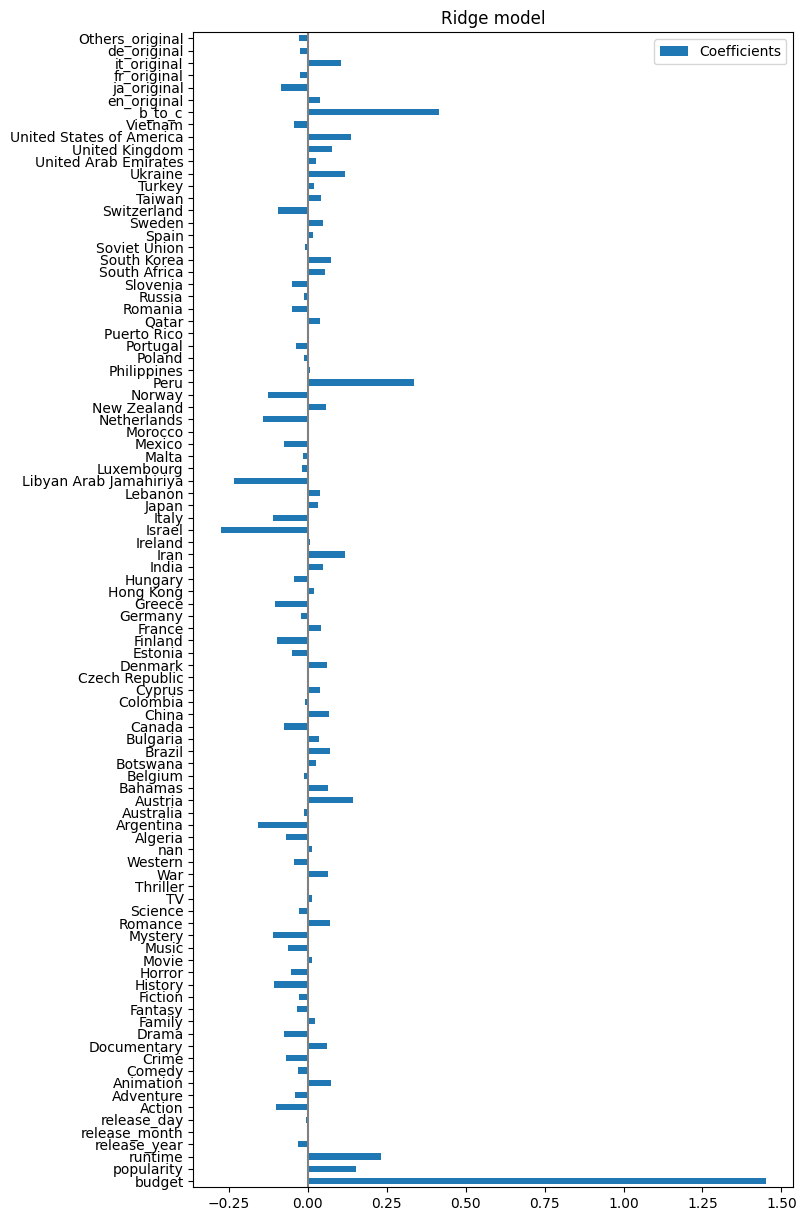

In [370]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_t.columns
)

coefs.plot(kind='barh', figsize=(10, 15))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [371]:
from sklearn.ensemble import RandomForestRegressor

In [372]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9592107327133979
model score on testing data: 0.29234950478220934


In [373]:
importances = model.feature_importances_

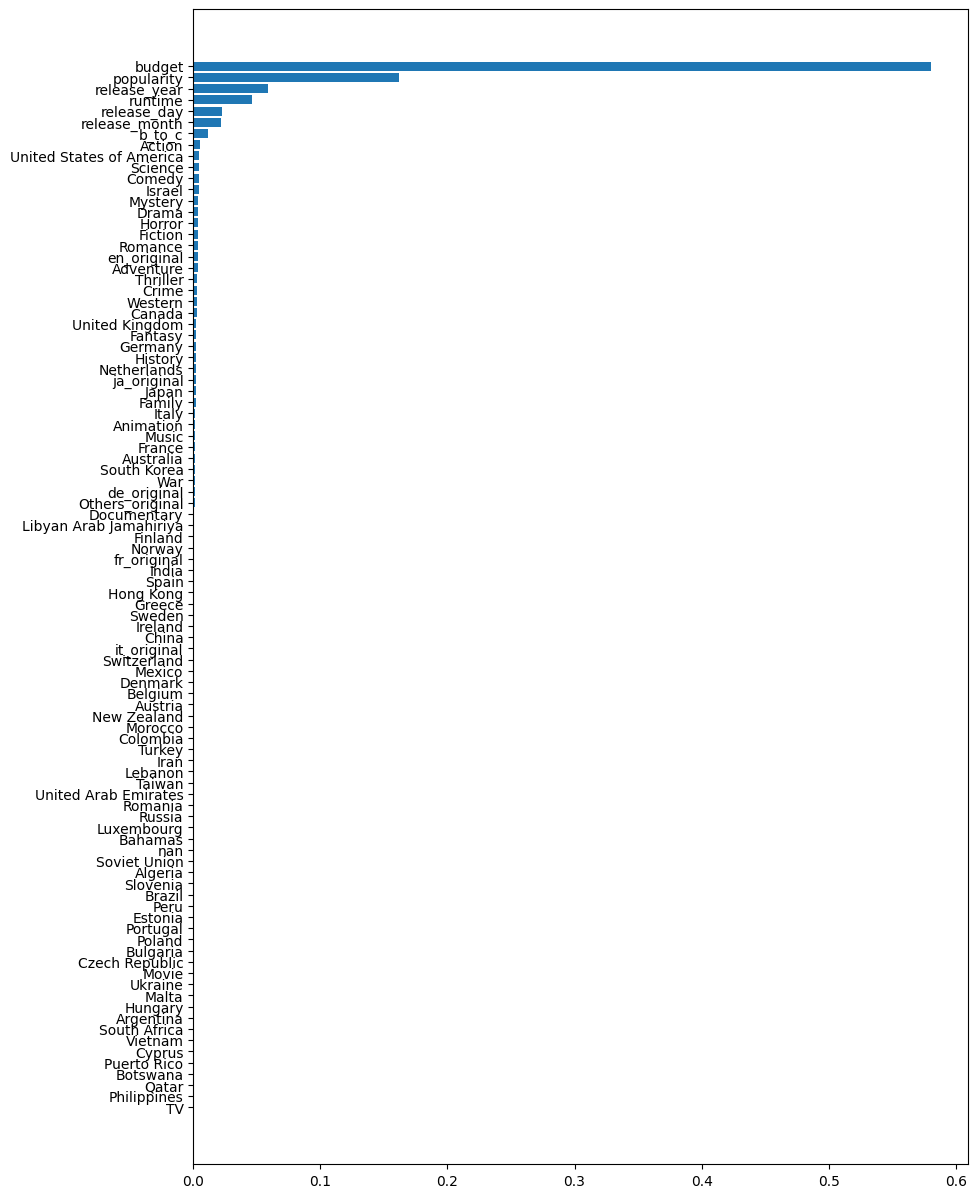

In [374]:
indices = np.argsort(importances)


fig, ax = plt.subplots(figsize=(10, 15))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_t.columns)[indices])